In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

## Data preprocessing

In [3]:
AQI_df = pd.read_csv("data_daily.csv")
AQI_df

,Date,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,AQI,target,station_n
0,2013-03-01,8.625000,16.875000,7.375000,44.573821,870.833333,75.791667,1.691667,1024.816667,-19.691667,0.0,2.350000,76.0,4,1
1,2013-03-01,7.541667,12.375000,15.583333,18.731431,362.500000,76.833333,0.016667,1023.783333,-21.941667,0.0,2.933333,77.0,4,2
2,2013-03-01,6.416667,9.875000,8.416667,29.443274,416.666667,71.625000,1.325000,1028.783333,-21.466667,0.0,3.308333,72.0,4,8
3,2013-03-01,6.375000,12.708333,3.000000,34.634057,204.166667,81.958333,0.812500,1023.858333,-19.583333,0.0,2.133333,82.0,4,11
4,2013-03-01,8.041667,10.750000,7.416667,19.609941,350.000000,56.708333,2.062500,1025.904167,-19.708333,0.0,2.608333,57.0,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17527,2017-02-28,14.875000,32.708333,6.500000,43.871490,570.833333,55.500000,10.958333,1014.887500,-12.783333,0.0,2.058333,56.0,4,3
17528,2017-02-28,23.583333,37.541667,4.083333,32.875000,700.000000,64.583333,8.554167,1009.791667,-10.891667,0.0,2.162500,65.0,4,2
17529,2017-02-28,13.708333,34.000000,5.708333,28.833333,529.166667,41.791667,9.754167,1011.287500,-13.612500,0.0,2.337500,42.0,5,1
17530,2017-02-28,13.125000,22.041667,6.375000,12.276608,412.500000,80.708333,10.187500,1010.116667,-11.704167,0.0,2.350000,81.0,4,11


In [3]:
# sorted_df = AQI_df.sort_values(by=["station_n", "Date"])

In [4]:
# AQI_df = sorted_df.head(1450)

In [8]:
AQI_df['Date'] = pd.to_datetime(AQI_df.Date, format='%Y-%m-%d')

AQI_ts = pd.Series(AQI_df.AQI.values, index=AQI_df.Date)

## Linear and expedetional trend models

Linear trend model

- The linear trend model is used for time series analysis because it provides a simple way to identify the overall direction of change in data over time and make basic forecasts


In [9]:
AQI_df = tsatools.add_trend(AQI_ts, trend='ct')

# Rename 0 to AQI_calculated 
AQI_df = AQI_df.rename(columns={0: 'AQI_calculated'})
AQI_df

,AQI_calculated,const,trend
Date,,,
2013-03-01,76.0,1.0,1.0
2013-03-01,77.0,1.0,2.0
2013-03-01,72.0,1.0,3.0
2013-03-01,82.0,1.0,4.0
2013-03-01,57.0,1.0,5.0
...,...,...,...
2017-02-28,56.0,1.0,17528.0
2017-02-28,65.0,1.0,17529.0
2017-02-28,42.0,1.0,17530.0


As part of Linear trend, we are going to use Orinart Least Squares method

- Linear Trend: Values change at a constant rate, resulting in a straight-line pattern over time. Common in scenarios with consistent growth or decline.
-  Ordinary Least Squares (OLS) method is used in linear regression analysis, because it efficiently finds the line that best fits data by minimizing the squared differences between observed and predicted values. 
- The dependent variable in the regression model is "AQI_calculated", while "trend"
is the independent variable.
- The formula 'AQI_calculted ~ trend' specifies the relationship between these variables as "Ridership" being a linear function of "trend". 
- The output of this line is an OLS model object ridership_lm that can be used for predicting future values and performing statistical tests on the model.


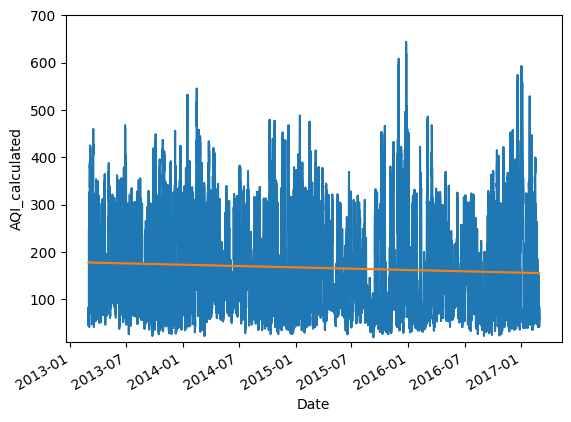

In [10]:
AQI_lm = sm.ols(formula='AQI_calculated ~ trend', data=AQI_df).fit()
# shorter and longer time series
ax = AQI_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('AQI_calculated')
ax.set_ylim(10, 700)
AQI_lm.predict(AQI_df).plot(ax=ax)
plt.show()

In [11]:
# split data into training and validation sets
train_df = AQI_df.loc[:'2016-1']
valid_df = AQI_df.loc['2016-1':]

# fit linear model using training set and predict on validation set
AQI_lm = sm.ols(formula='AQI_calculated ~ trend', data=train_df).fit()
predict_df = AQI_lm.predict(valid_df)

In [12]:
# create the plot
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('2013', '2017-5')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])
    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('2013', ypos, 'Training')
    ax.text('2017-5', ypos, 'Validation')

In [13]:
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [0, 700], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='AQI_calculated', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='AQI_calculated', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('AQI_calculated')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend():
        axes[0].get_legend().remove()

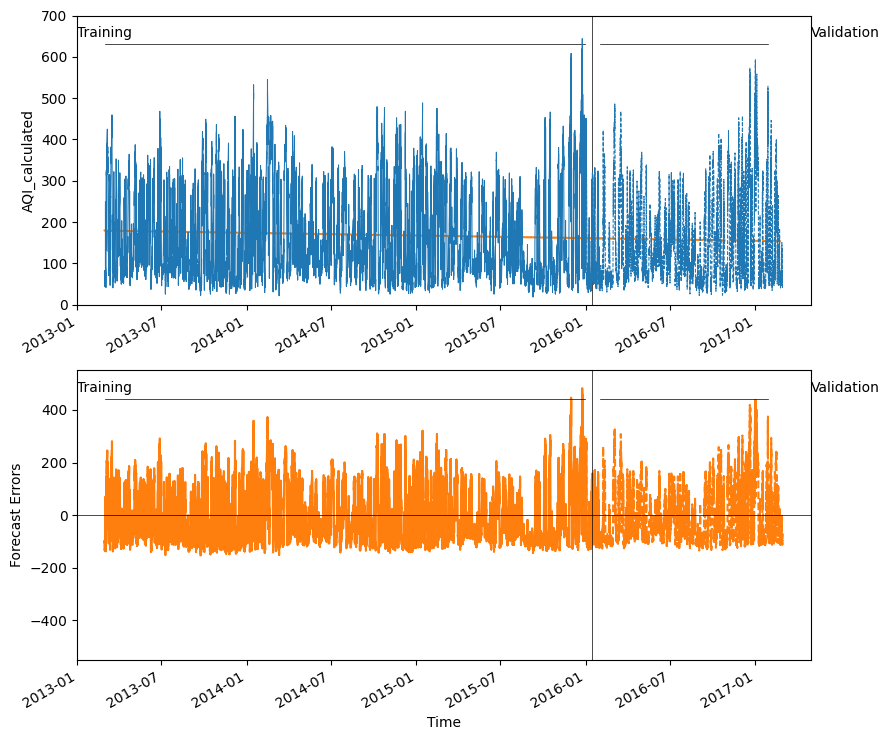

In [14]:
# plot the results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
AQI_lm.predict(train_df).plot(ax=axes[0], color='C1')
AQI_lm.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
residual = train_df.AQI_calculated - AQI_lm.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.AQI_calculated - AQI_lm.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

Forecast errors in the given graph are the differences between the actual observed values and the values predicted by the model.

Exponential Trend:

- Exponential Trend: Values change at an accelerating rate, following a percentage increase or decrease over time. 
- Exponential trends show rapid and accelerating changes, while linear trends depict steady and consistent changes. The choice between them depends on the data's nature and context.


EXPONENTIAL (GREEN) AND LINEAR (ORANGE) TREND USED TO FORECAST AQI dataset


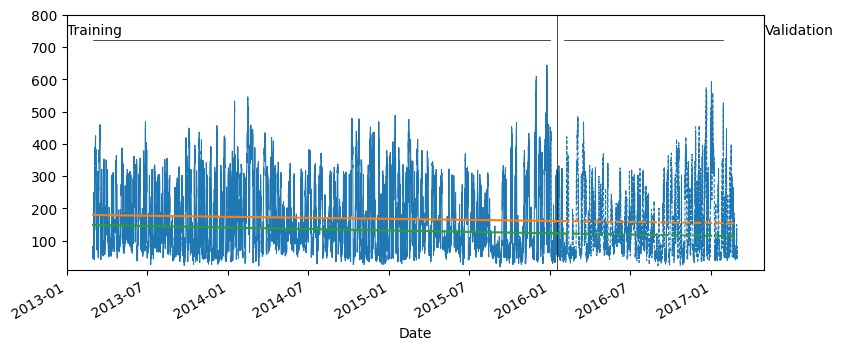

In [15]:
print('EXPONENTIAL (GREEN) AND LINEAR (ORANGE) TREND USED TO FORECAST AQI dataset')
#Linear regression model for AQI_calculated
AQI_lm_linear = sm.ols(formula='AQI_calculated ~ trend', data=train_df).fit()

#Predict ridership using the linear model
predict_df_linear = AQI_lm_linear.predict(valid_df)

#Exponential regression model for ridership
AQI_lm_expo = sm.ols(formula='np.log(AQI_calculated) ~ trend', data=train_df).fit()

#Predict ridership using the exponential model
predict_df_expo = AQI_lm_expo.predict(valid_df)

#Create a subplot for the graph and set its dimensions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,3.75))

#Plot the training data
train_df.plot(y='AQI_calculated', ax=ax, color='C0', linewidth=0.75)

#Plot the validation data
valid_df.plot(y='AQI_calculated', ax=ax, color='C0', linestyle='dashed', linewidth=0.75)

#Set the layout of the graph using the function singleGraphLayout
singleGraphLayout(ax, [10, 800], train_df, valid_df)

#Plot the linear model predictions for the training data
AQI_lm_linear.predict(train_df).plot(color='C1')

#Plot the linear model predictions for the validation data
AQI_lm_linear.predict(valid_df).plot(color='C1', linestyle='dashed')

#Plot the exponential model predictions for the training data
AQI_lm_expo.predict(train_df).apply(lambda row: math.exp(row)).plot(color='C2')

#Plot the exponential model predictions for the validation data
AQI_lm_expo.predict(valid_df).apply(lambda row: math.exp(row)).plot(color='C2', linestyle='dashed')

#Remove the legend
ax.get_legend().remove()

#Display the graph
plt.show()

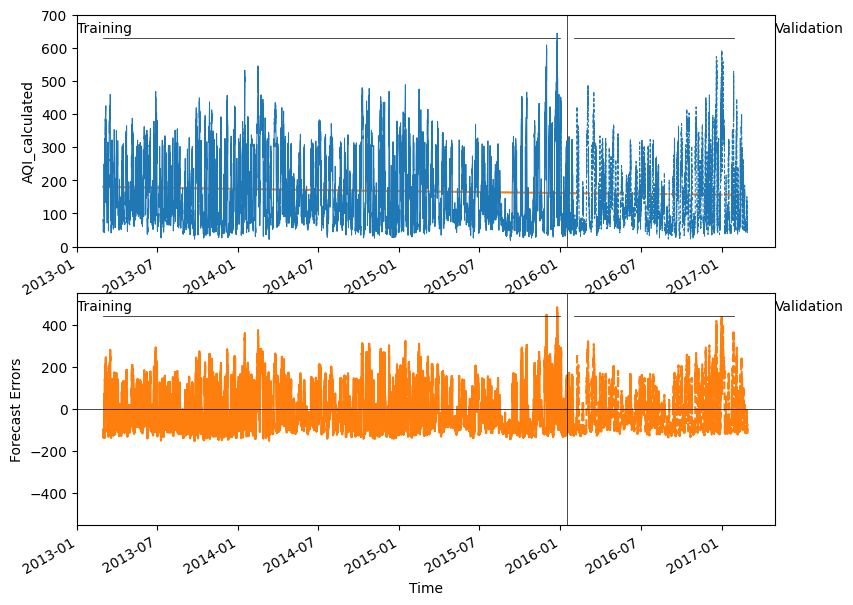

In [16]:
AQI_calculated_lm_poly = sm.ols(formula='AQI_calculated ~ trend + np.square(trend)',
data=train_df).fit()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
AQI_calculated_lm_poly.predict(train_df).plot(ax=axes[0], color='C1')
AQI_calculated_lm_poly.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
residual = train_df.AQI_calculated - AQI_calculated_lm_poly.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.AQI_calculated - AQI_calculated_lm_poly.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()

## Autocorrelation 

- Autocorrelation is a statistical concept that measures the correlation between a time series variable and a lagged version of itself. It assesses how a variable's values at one time point are related to its values at previous time points. Autocorrelation can provide insights into repeating patterns or trends in time series data.
- Lag refers to the time interval between a data point and the data point being compared to it.

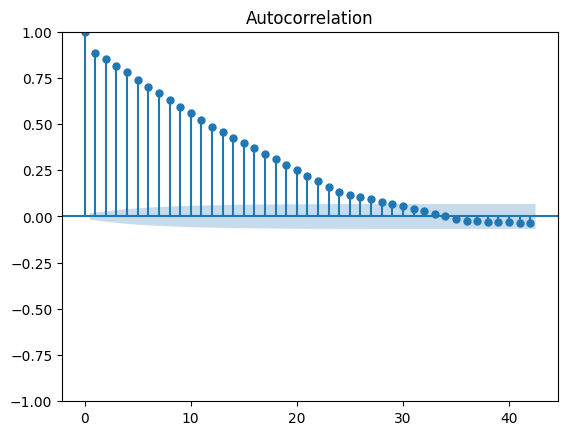

In [17]:
tsaplots.plot_acf(train_df['2013-01':'2017-01'].AQI_calculated)
plt.show()
